In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# scipy.integrate.dplquad: a package to compute a double integration
from scipy.integrate import dblquad

### Instead of a ready-to-use integrate package, we use Monte Carlo Integration ###
from time import time

import warnings
warnings.filterwarnings('ignore')

# translates python into more GPU CPU efficient codes and speeds up the simulation
from numba import jit

# for plotting colored plots
from seaborn import color_palette

# for the latin hypercube sampling ---> installation of scikit-optimize necessary
# run pip install scikit-optimize 
# or look at: https://scikit-optimize.github.io/stable/install.html
import skopt
from skopt.space import Space
from skopt.sampler import Lhs

import scipy
from scipy import stats
from scipy.stats import rv_histogram
from scipy.stats import norm

import pandas as pd

from tqdm import tqdm

df = pd.read_csv('Areas.csv')

# Visualize the Mandelbrot set

This is how the area of Mandelbrot set is define. 
Let's define a function $\chi_M$ on the complex plane by
$$\chi_M(z) = \left\{
\begin{array}{ll}
    1 & \text{if } z \text{ is within the Mandelbrot set} \\
    0 & \text{if } z \text{ is outside of the Mandelbrot set}.
\end{array}\right.$$
Then,
$$A_M = \iint_{\mathbb C} \chi_M(x+iy) \, dA$$
should be the area of the Mandelbrot set.

The approximated $A_{i,s}$ converges to $A_M$ when the number of iterations $i \rightarrow \inf$ and the number of samples drawn $s \rightarrow \inf$

Note that a complex number $c$ is in the Mandelbrot set by definition if the orbit of the critical point zero under iteration of
$$z_{n+1}=z_{n}^2+c$$
remains bounded. 

In [2]:
@jit
def critical_orbit_count(c, max_iters=100):
#     z = c + 0.0j
    z = c 
    cnt = 0
    while(z.real**2 + z.imag**2 <= 4 and cnt < max_iters):
        z = z*z+c
        cnt = cnt+1
    return cnt

@jit
def critical_colors(cmin, cmax, max_iters = 100, resolution=200):
    palette = color_palette("Greens_r", max_iters)
    xs = [cmin.real, cmax.real]
    xs.sort()
    xmin,xmax = xs
    ys = [cmin.imag, cmax.imag]
    ys.sort()
    ymin,ymax = ys
    
    xrange = xmax-xmin
    yrange = ymax-ymin
    if xrange >= yrange:
        xdim = int(resolution)
        ydim = int(xdim*(yrange/xrange))
        delta = xrange/xdim
    else:
        ydim = int(resolution)
        xdim = int(ydim*(xrange/yrange))
        delta = yrange/resolution

    colors = np.zeros((ydim,xdim,3))
    for i in range(ydim):
        for j in range(xdim):
            c = complex(xmin + j*delta, ymin + i*delta)
            count = critical_orbit_count(c, max_iters)
            if count < max_iters:
                colors[i,j] = palette[count]
    
    return colors

cmin = -2-1.3j
cmax = 0.6+1.3j

precompile = critical_colors(cmin,cmax, max_iters = 20, resolution=20)
t = time()
colors = critical_colors(cmin,cmax, max_iters = 100, resolution=800)
time()-t

precompile2 = critical_colors(cmin,cmax, max_iters = 200, resolution=20)
t = time()
colors2 = critical_colors(cmin,cmax, max_iters = 1000, resolution=800)
time()-t

0.6067345142364502

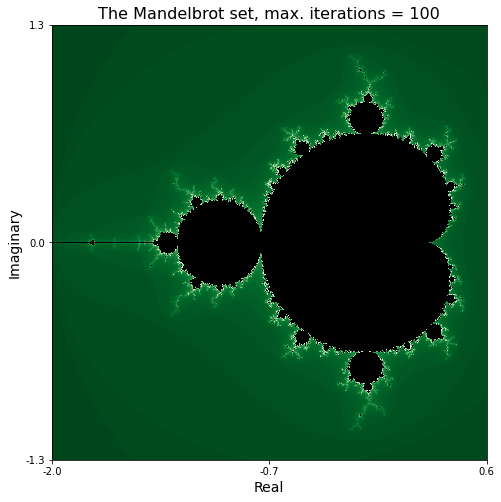

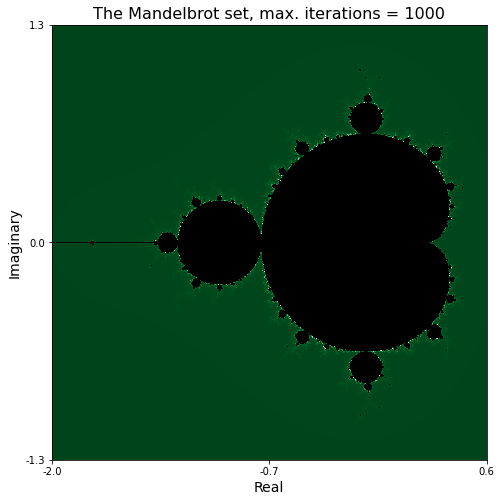

In [3]:
plt.figure(figsize=(8,8))
plt.imshow(colors, zorder=1, interpolation='none')

yres,xres = colors.shape[:2]
ax = plt.gca()
ax.set_yticks([0,yres/2,yres])
ax.set_yticklabels([cmax.imag, (cmax.imag+cmin.imag)/2, cmin.imag])
ax.set_xticks([0,xres/2,xres])
ax.set_xticklabels([cmin.real, (cmax.real+cmin.real)/2, cmax.real])
ax.set_ylabel('Imaginary', fontsize=14)
ax.set_xlabel('Real', fontsize=14)
ax.set_title('The Mandelbrot set, max. iterations = 100', fontsize=16)
plt.savefig('mandelbrot_100.png', dpi=300)

plt.figure(figsize=(8,8))
plt.imshow(colors2, zorder=1, interpolation='none')

yres,xres = colors2.shape[:2]

ax = plt.gca()
ax.set_yticks([0,yres/2,yres])
ax.set_yticklabels([cmax.imag, (cmax.imag+cmin.imag)/2, cmin.imag])
ax.set_xticks([0,xres/2,xres])
ax.set_xticklabels([cmin.real, (cmax.real+cmin.real)/2, cmax.real])
ax.set_ylabel('Imaginary', fontsize=14)
ax.set_xlabel('Real', fontsize=14)
ax.set_title('The Mandelbrot set, max. iterations = 1000', fontsize=16)

plt.savefig('mandelbrot_1000.png', dpi=300)

## Statistical Tests 

Normality of the samples

One-sample test: compared to the literature values 

Two-sample Welch test: compared expected value difference 

Two-sample F-Test / Fischer: compared the robustness

In [6]:
# Shapiro-Wilk test to examine normality of results from each sampling

def test_normality(data,p=0.95):
    """
    Perform the Shapiro-Wilk test for normality.
    The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution
    
    Argument: 
        data : tested sample population
        p : confidence level
    Returns:
        stats : test statistic of Shapiro-Wilk 
        pval : p-value of the test
    
    Note:
        If the p-value is less than significant level (1-p), we reject the null hypothesis that 
        there's no difference between the means and conclude that a significant 
        difference does exist. If the p-value is larger than 0.05, we cannot 
        conclude that a significant difference exists.
    """

    statics, pval = stats.shapiro(data)[0], stats.shapiro(data)[1]
    
    print(f'the w test statistic is {statics}, the p-value is {pval}')
    if pval <= (1-p):
        print(f'We reject H0, the sample is not normally distributed at {int(100*p)} confidence interval')
    else:
        print(f'We accept H0, the sample is tested to be normally distributed at {int(100*p)} confidence interval')
    return statics, pval

# Student T-test to compare the results from 3 samplings to the literature value

def student_t_onesample(x,x0,p):
    """
    Student-T test to test whether the expected value of the sample to a target value equal,
    with null hypothesis H0: E(x) = x0
    
    Arguments:
        x: estimated area
        x0: the given estimated value from other literature
        p: the provided confidence interval
    Returns:
        act: the actual value of t-test
        res: the acceptance result of this test, True means do not reject H0, False means reject H0
    """
    avg_sample = np.mean(x)
    sample_size = len(x)
    sample_std = np.std(x,ddof=1)
    
    act = (avg_sample - x0) / (sample_std / np.sqrt(sample_size))
    
    crit_val = scipy.stats.t.ppf(q=(p+1)/2,df=sample_size-1)
    res = True
    if abs(act) >= crit_val:
        res = False
        print(f'We reject H0 with actual t-statistic = {act} at confidence level p = {p} (critical value = {crit_val})')
    else:
        print(f'We do not reject H0 with actual t-statistic = {act} at confidence level p = {p} (critical value = {crit_val})')
        
    return act, res

# Two-sample Welch test : compared expected value difference by different samplings

def welch_test(x1,x2,p):
    """
    Welch test to evaluate whether the expected value two groups samples equal
    H0: E(x1) = E(x2)
    
    Arguments
        x1 : samples group 1
        x2 : samples group 2
        p : the provided confidence interval
        
    Returns:
        act: the actual value of Welch test
        pval: p-value of the test
        res: the acceptance result of this test, True means do not reject H0, False means reject H0
    """
    x1_var = np.var(x1,ddof=1)
    x2_var = np.var(x2,ddof=1)
    x1_avg = np.mean(x1)
    x2_avg = np.mean(x2)
    
    pool_var = (x1_var / x1.size)  + (x2_var / x2.size) 
    act = (x1_avg-x2_avg) / (np.sqrt(pool_var))

    dof = (x1_var/x1.size + x2.var()/x2.size)**2 / ((x1_var/x1.size)**2 / (x1.size-1) + (x2.var()/x2.size)**2 / (x2.size-1))
    print(f'the Welch-T test statistic is {act}, the degree-of-freedom is {dof}')
    crit_val = scipy.stats.t.ppf(q=(p+1)/2,df=dof)
    res = False
    if abs(act) > crit_val:
        res = True
        print(f'We reject H0 with actual t-statistic = {act} at confidence level p = {p} (critical value = {crit_val})')
    else:
        print(f'We do not reject H0 with actual t-statistic = {act} at confidence level p = {p} (critical value = {crit_val})')

    return act, res, dof

# Two-sample F-Test / Fischer Test: compared the variance of different population
def f_test(x1,x2,p):
    act = max([x1.var()/x2.var(),x2.var()/x1.var()])
    crit_val1 = scipy.stats.f.ppf(1-(1-p)/2, x1.size-1, x2.size-1)
    crit_val2 = scipy.stats.f.ppf((1-p)/2, x1.size-1, x2.size-1)

    res = True
    if act > crit_val1 or act < crit_val2:
        res = False
        print(f'We reject H0 with actual t-statistic = {act} at confidence level p = {p} (critical value = {crit_val2}-{crit_val1})')
    else:
        print(f'We do not reject H0 with actual t-statistic = {act} at confidence level p = {p} (critical value = {crit_val2}-{crit_val1})')
    return act, res

# Samplings Functions

In [7]:
@jit(nopython=True)
def random_sampling(real_range, comp_range, sample_size=1, seed=0):
    """
    Returns array of N random complex numbers within given range
    Arguments:
        real_range       range for the real part of the complex numbers
        comp_range       range for the imaginary part of the complex numbers
        sample_size      size of the sample to be generated
        seed             random seed - needs to be set within the function because of numba
    Returns:
        random_complex   a numpy array contain sample_size random complex numbers within
                         the specified ranges
    """
    #random_complex = np.zeros(N)
    #np.random.seed(seed)

    # uniform sampling of real and complex 
    X = (real_range[1]-real_range[0])*np.random.random(sample_size) + real_range[0]
    Y = (comp_range[1]-comp_range[0])*np.random.random(sample_size) + comp_range[0]
    random_complex = X + Y * 1j
    
    return random_complex

@jit
def lhs_sampling(real_range, comp_range, sample_size=1, seed=0):
    """
    Latin hypercube sampling with 2 dimensions
    Arguments:
        real_range       range for the real part of the complex numbers
        comp_range       range for the imaginary part of the complex numbers
        sample_size      size of the sample to be generated
        seed             random seed - needs to be set within the function because of numba
    Returns:
        random_complex   a numpy array contain sample_size random complex numbers within
                         the specified ranges
    """
    #np.random.seed(seed)
    space = Space([real_range, comp_range])
    
    lhs = Lhs(lhs_type="classic", criterion=None)
    samples = lhs.generate(space.dimensions, sample_size)
    
    samples = np.array(samples)
    X = samples[:,0]
    Y = samples[:,1]
    random_complex = X + Y * 1j
    return random_complex

@jit(nopython=True)
def ortho_sampling(real_range, comp_range, sample_size, seed=0):
    """
    Code partly adapted from the ortho code accompanying the assignment which is based on methods designed by
    Tang (1993)
    
    Orthogonal sampling with 2 dimensions (major and minor grid)
    Arguments:
        real_range       range for the real part of the complex numbers
        comp_range       range for the imaginary part of the complex numbers
        sample_size      size of the sample to be generated
        seed             random seed - needs to be set within the function because of numba
    Returns:
        random_complex   a numpy array contain sample_size random complex numbers within
                         the specified ranges
    """                         
    # assert(np.sqrt(sample_size) % 1 == 0), "Please insert a number of sample size which can be squared to integer"
        
    MAJOR = round(np.sqrt(sample_size))
    MINOR = MAJOR
    
    # xlist gives column, first of major grid, then of minor grid
    # ylist gives row, first major then minor
    xlist = np.zeros((MAJOR,MINOR))
    ylist = np.zeros((MAJOR,MINOR))

    # create initial matrices
    m = 0
    for i in range(MAJOR):
        for j in range(MINOR):
            xlist[i][j] = m
            ylist[i][j] = m
            m += 1

    # permute these matrices
    for i in range(MAJOR):
        xlist[i] = np.random.permutation(xlist[i])
        ylist[i] = np.random.permutation(ylist[i])
        
    # need to position point in the subsubsquare randomly
    # scale is length of interval divided by number of subsubgrid, so major * minor
    x_scale = (real_range[1] - real_range[0]) / (MAJOR * MINOR)
    y_scale = (comp_range[1] - comp_range[0]) / (MAJOR * MINOR)
    
    random_complex = np.zeros(MAJOR*MINOR, dtype=np.complex64)
    
    entry_number = 0
    for i in range(MAJOR):
        for j in range(MINOR):
            x = real_range[0] + x_scale * (xlist[i][j] + np.random.random())
            y = comp_range[0] + y_scale * (ylist[j][i] + np.random.random())
            
            random_complex[entry_number] = x + y * 1j
            entry_number += 1
            
    return random_complex

In [8]:
@jit(nopython=True)
def find_area_Mandelbrot(real_range, comp_range, C, max_iters=100):
    """
    Estimates the area of the Mandelbrot set by using the accept-reject
    Monte Carlo method on a sample C of complex numbers
    Arguments:
        real_range       range for the real part of the complex numbers
        comp_range       range for the imaginary part of the complex numbers
        C                sample of complex numbers within the specified range
        max_iters        the maximum number of iterations to check if the quadratic
                         polynomial diverges for c in the sample or not
    Returns:
        area             estimation of the area
        M                index for the sample C of accepted points (to be used for plotting)
    """
    
    Z = np.zeros_like(C)
    T = np.zeros(C.shape)
    
    for k in range(max_iters):
        # check for each z in Z if distance is less than 2
        # get array with True or False on corresponding position
        M = Z.real ** 2 + Z.imag ** 2 < 4
        
        # update orbit
        Z[M] = Z[M] ** 2 + C[M]
        
        # save iterations for these M
        T[M] = k + 1
    
    total = np.count_nonzero(T == max_iters)
    area = (total/len(C)) * (real_range[1] - real_range[0]) * (comp_range[1] - comp_range[0])
    
    return area, M

In [9]:
# for the control variate sampling
def opt_c(x,y):
    """
    Calculate the optimal coefficient c used for control variate sampling 
    """
    matric_cov_xy = np.cov(x,y)
    cov_xy = matric_cov_xy[0][1]
    var_y = matric_cov_xy[1][1]

    # through a big sampling we obtain the coefficient c
    opt_c = - cov_xy/var_y
    
    return opt_c

@jit(nopython=True)
def random_sampling_control(real_range, comp_range, sample_size=1, seed=0):
    """
    Returns array of N random complex numbers within given range
    Arguments:
        real_range       range for the real part of the complex numbers
        comp_range       range for the imaginary part of the complex numbers
        sample_size      size of the sample to be generated
        seed             random seed - needs to be set within the function because of numba
    Returns:
        random_complex   a numpy array contain sample_size random complex numbers within
                         the specified ranges
    """

    # uniform sampling of real and complex 
  
    sample_u1 = np.random.random(size=sample_size)
    sample_u2 = np.random.random(size=sample_size)
    
    # uniform sampling of real and complex 
    real = (real_range[1]-real_range[0])*sample_u1 + real_range[0]
    comp = (comp_range[1]-comp_range[0])*sample_u2 + comp_range[0]
    random_complex = real + comp * 1j
    
    
    return random_complex, sample_u1

def find_area_Mandelbrot_controlvariate(real_range, comp_range, sample, max_iters=100):
    """
    Estimates the area of the Mandelbrot set by using the accept-reject
    Monte Carlo method on a sample C of complex numbers
    Arguments:
        real_range       range for the real part of the complex numbers
        comp_range       range for the imaginary part of the complex numbers
        sample                tuple: (sample_complex, sample_u) sample of complex numbers within the specified range 
                                and the sample of uniform numbers used to generate the complex numbers
        max_iters        the maximum number of iterations to check if the quadratic
                         polynomial diverges for c in the sample or not
    Returns:
        area             estimation of the area
        M                index for the sample C of accepted points (to be used for plotting)
    """
    C = sample[0]
    U = sample[1]
    Z = np.zeros_like(C)
    T = np.zeros(C.shape)
    
    for k in range(max_iters):
        
        # check for each z in Z if distance is less than 2
        # get array with True or False on corresponding position
        M = Z.real ** 2 + Z.imag ** 2 < 4
        
        # update orbit
        Z[M] = Z[M] ** 2 + C[M]
        
        # save iterations for these M
        T[M] = k + 1
    
    # use the control variate method to shift g(X)
    g_sample = T == max_iters
    
    # find optimal c
    c = opt_c(g_sample*1,U)
    
    # shift g
    shifted_g = g_sample + c * (U - 0.5*np.ones(len(U)))
    
    total_control = np.sum(shifted_g)
    area_control = (total_control/len(C)) * (real_range[1] - real_range[0]) * (comp_range[1] - comp_range[0])
    
    total_random = np.count_nonzero(T == max_iters)
    area_random = (total_random/len(C)) * (real_range[1] - real_range[0]) * (comp_range[1] - comp_range[0])
    
    return area_control, area_random

# Final Simulations

In [10]:
import time

def repeated_simulation(repetition=100):
    """
    Function:
        Repeat the simulation of sampling and calculating Mandelbrot set area for multiple times
        Each simulation is seeded randomly
        
    Return: 
        The lists of running time for sampling and calculation of Mandelbrot set area 
        The lists of values of Mandelbrot area approximated from different sampling methods
    """
    seeds = np.random.randint(1, high=10000, size=repetition, dtype=int) 
    
    # define the range of real and complex part
    real_range = [-2.,0.6]
    comp_range =[-1.3,1.3]

    sample_size = 40000

    for x in range(1, 7):
        globals()['runtime%s' % x] = np.zeros(repetition)
    
    random_area = np.zeros(repetition)
    lhs_area = np.zeros(repetition)
    ortho_area = np.zeros(repetition)
    cv_area = np.zeros(repetition)
    
    for s in range(repetition):
        
        seed = seeds[s]

        # simulate samples by random_sampling, LHS_sampling or Orthogonal_sampling
        sample1 = random_sampling(real_range, comp_range, sample_size=sample_size, seed=seed)

        sample2 = lhs_sampling(real_range, comp_range, sample_size=sample_size, seed=seed)

        sample3 = ortho_sampling(real_range, comp_range, sample_size=sample_size, seed=seed)
        
        sample4 = random_sampling_control(real_range, comp_range, sample_size=sample_size, seed=seed)

        area1,_ = find_area_Mandelbrot(real_range, comp_range, sample1, max_iters=2500)
        random_area[s] = area1

        area2,_ = find_area_Mandelbrot(real_range, comp_range, sample2, max_iters=2500)
        lhs_area[s] = area2

        area3,_ = find_area_Mandelbrot(real_range, comp_range, sample3, max_iters=2500)
        ortho_area[s] = area3
        
        area4, _ = find_area_Mandelbrot_controlvariate(real_range, comp_range, sample4, max_iters=2500)
        cv_area[s] = area4

    all_estim_area = np.array([random_area,lhs_area,ortho_area,cv_area])
    print(f'there are {repetition}')
    
    return all_estim_area, seeds

#### Uncomment the next 2 cells to generate new data, leave commented to only generate the plot using data provided in the repository

In [19]:
#all_estim_area,seeds = repeated_simulation(repetition=100)

there are 100


In [11]:
# all_estim_area = np.transpose(all_estim_area)

# df = pd.DataFrame(all_estim_area,
#                  columns=['Random', 'LHS', 'Orthogonal','Control Variate'])

# df.to_csv('Areas.csv')

df = pd.read_csv('Areas.csv')

Text(0.5, 0, 'Sampling Types')

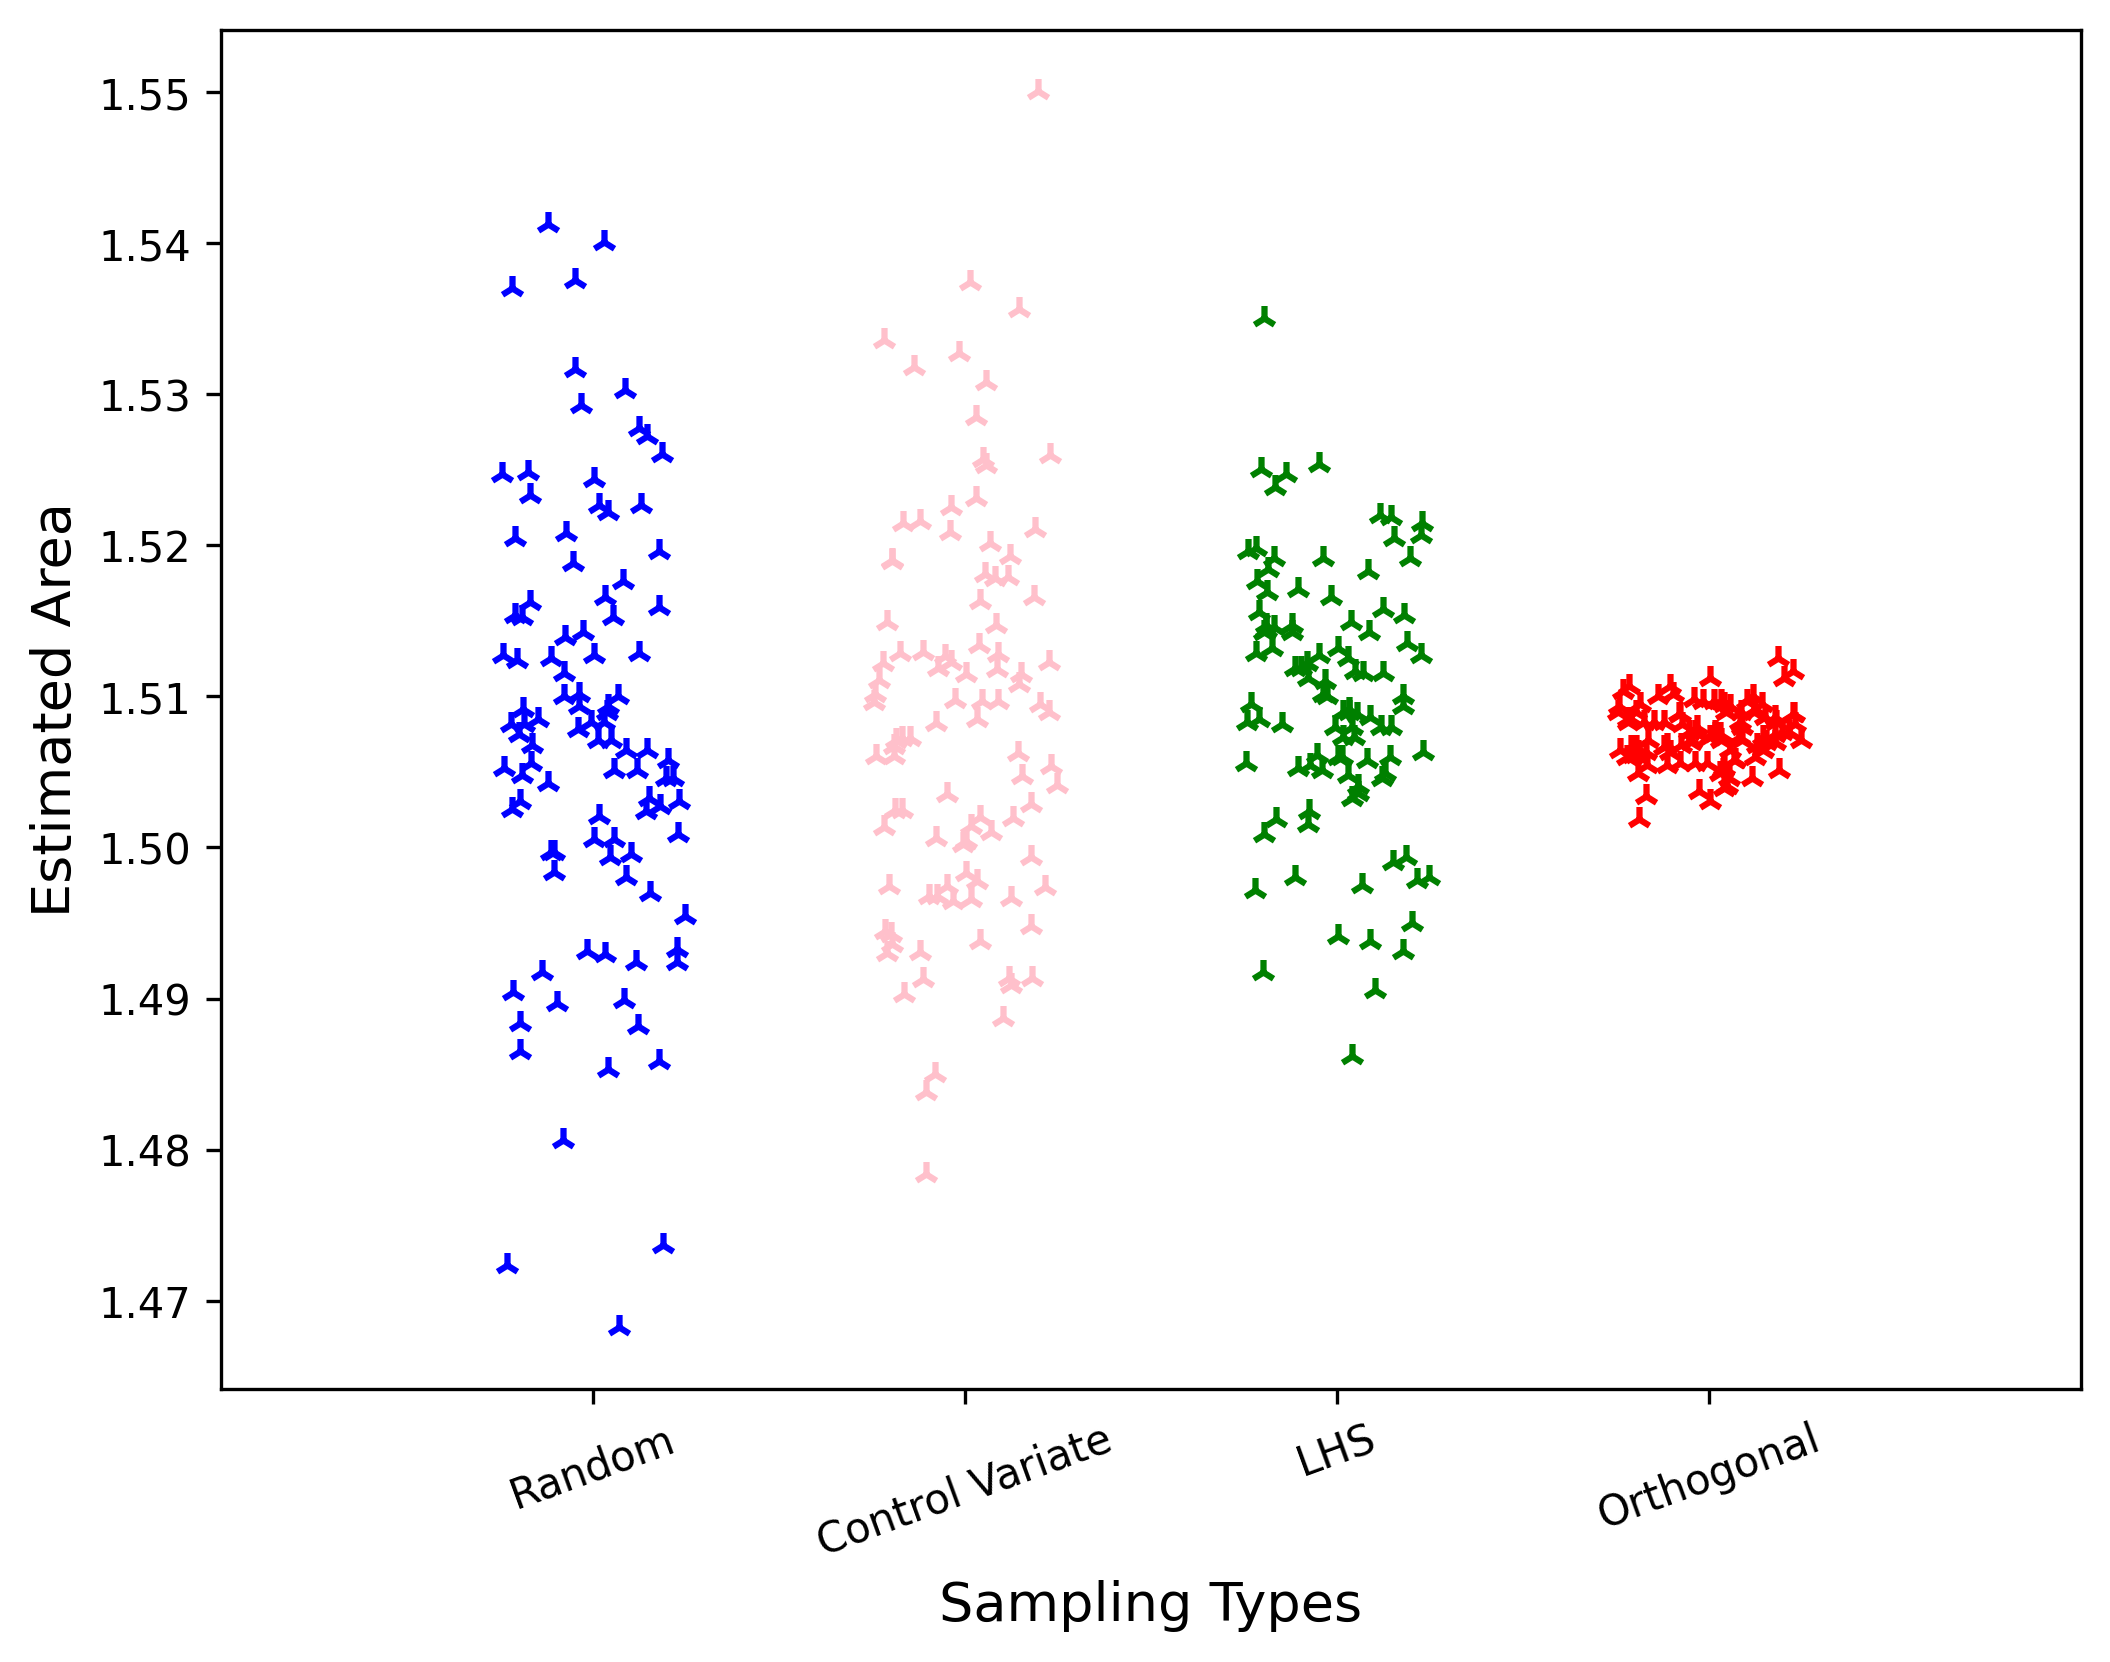

In [12]:
# dot plot
fig, ax = plt.subplots(figsize=(8,6),dpi=300)

x = [ 1, 2, 3, 4]

labels = ['Random','Control Variate','LHS','Orthogonal']
ax.set_xlim(0,5)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20)

# standard errors
std1 = np.std(df['Random'],ddof=1)
std2 = np.std(df['LHS'],ddof=1)
std3 = np.std(df['Orthogonal'],ddof=1)
std4 = np.std(df['Control Variate'],ddof=1)


# mean values
mean1 = np.mean(df['Random'])
mean2 = np.mean(df['LHS'])
mean3 = np.mean(df['Orthogonal'])
mean4 = np.mean(df['Control Variate'])
mean5 = 1.50659177

# the critical value for 95% confidence intervals
CI = 0.95
CV = norm.ppf(CI+(1-CI)/2) 

# confidence intervals
ci_1 = CV * std1/np.sqrt(len(df['Random']))
ci_2 = CV * std2/np.sqrt(len(df['LHS']))
ci_3 = CV * std3/np.sqrt(len(df['Orthogonal']))
ci_4 = CV * std4/np.sqrt(len(df['Control Variate']))


# to make the scatter plot clearer, we add small noise to the category axis (x_axis)
random_loc = np.random.uniform(low=-0.25, high=0.25, size=len(df))

ax.scatter(np.ones(len(df)) + random_loc, df['Random'], marker = "2", color = 'b')
ax.scatter(2*np.ones(len(df)) + random_loc, df['Control Variate'], marker = "2", color = 'pink')
ax.scatter(3*np.ones(len(df)) + random_loc, df['LHS'], marker = "2", color = 'g')
ax.scatter(4*np.ones(len(df)) + random_loc, df['Orthogonal'], marker = "2", color = 'r')


ax.set_ylabel('Estimated Area',fontsize=13)
ax.set_xlabel('Sampling Types',fontsize=13)

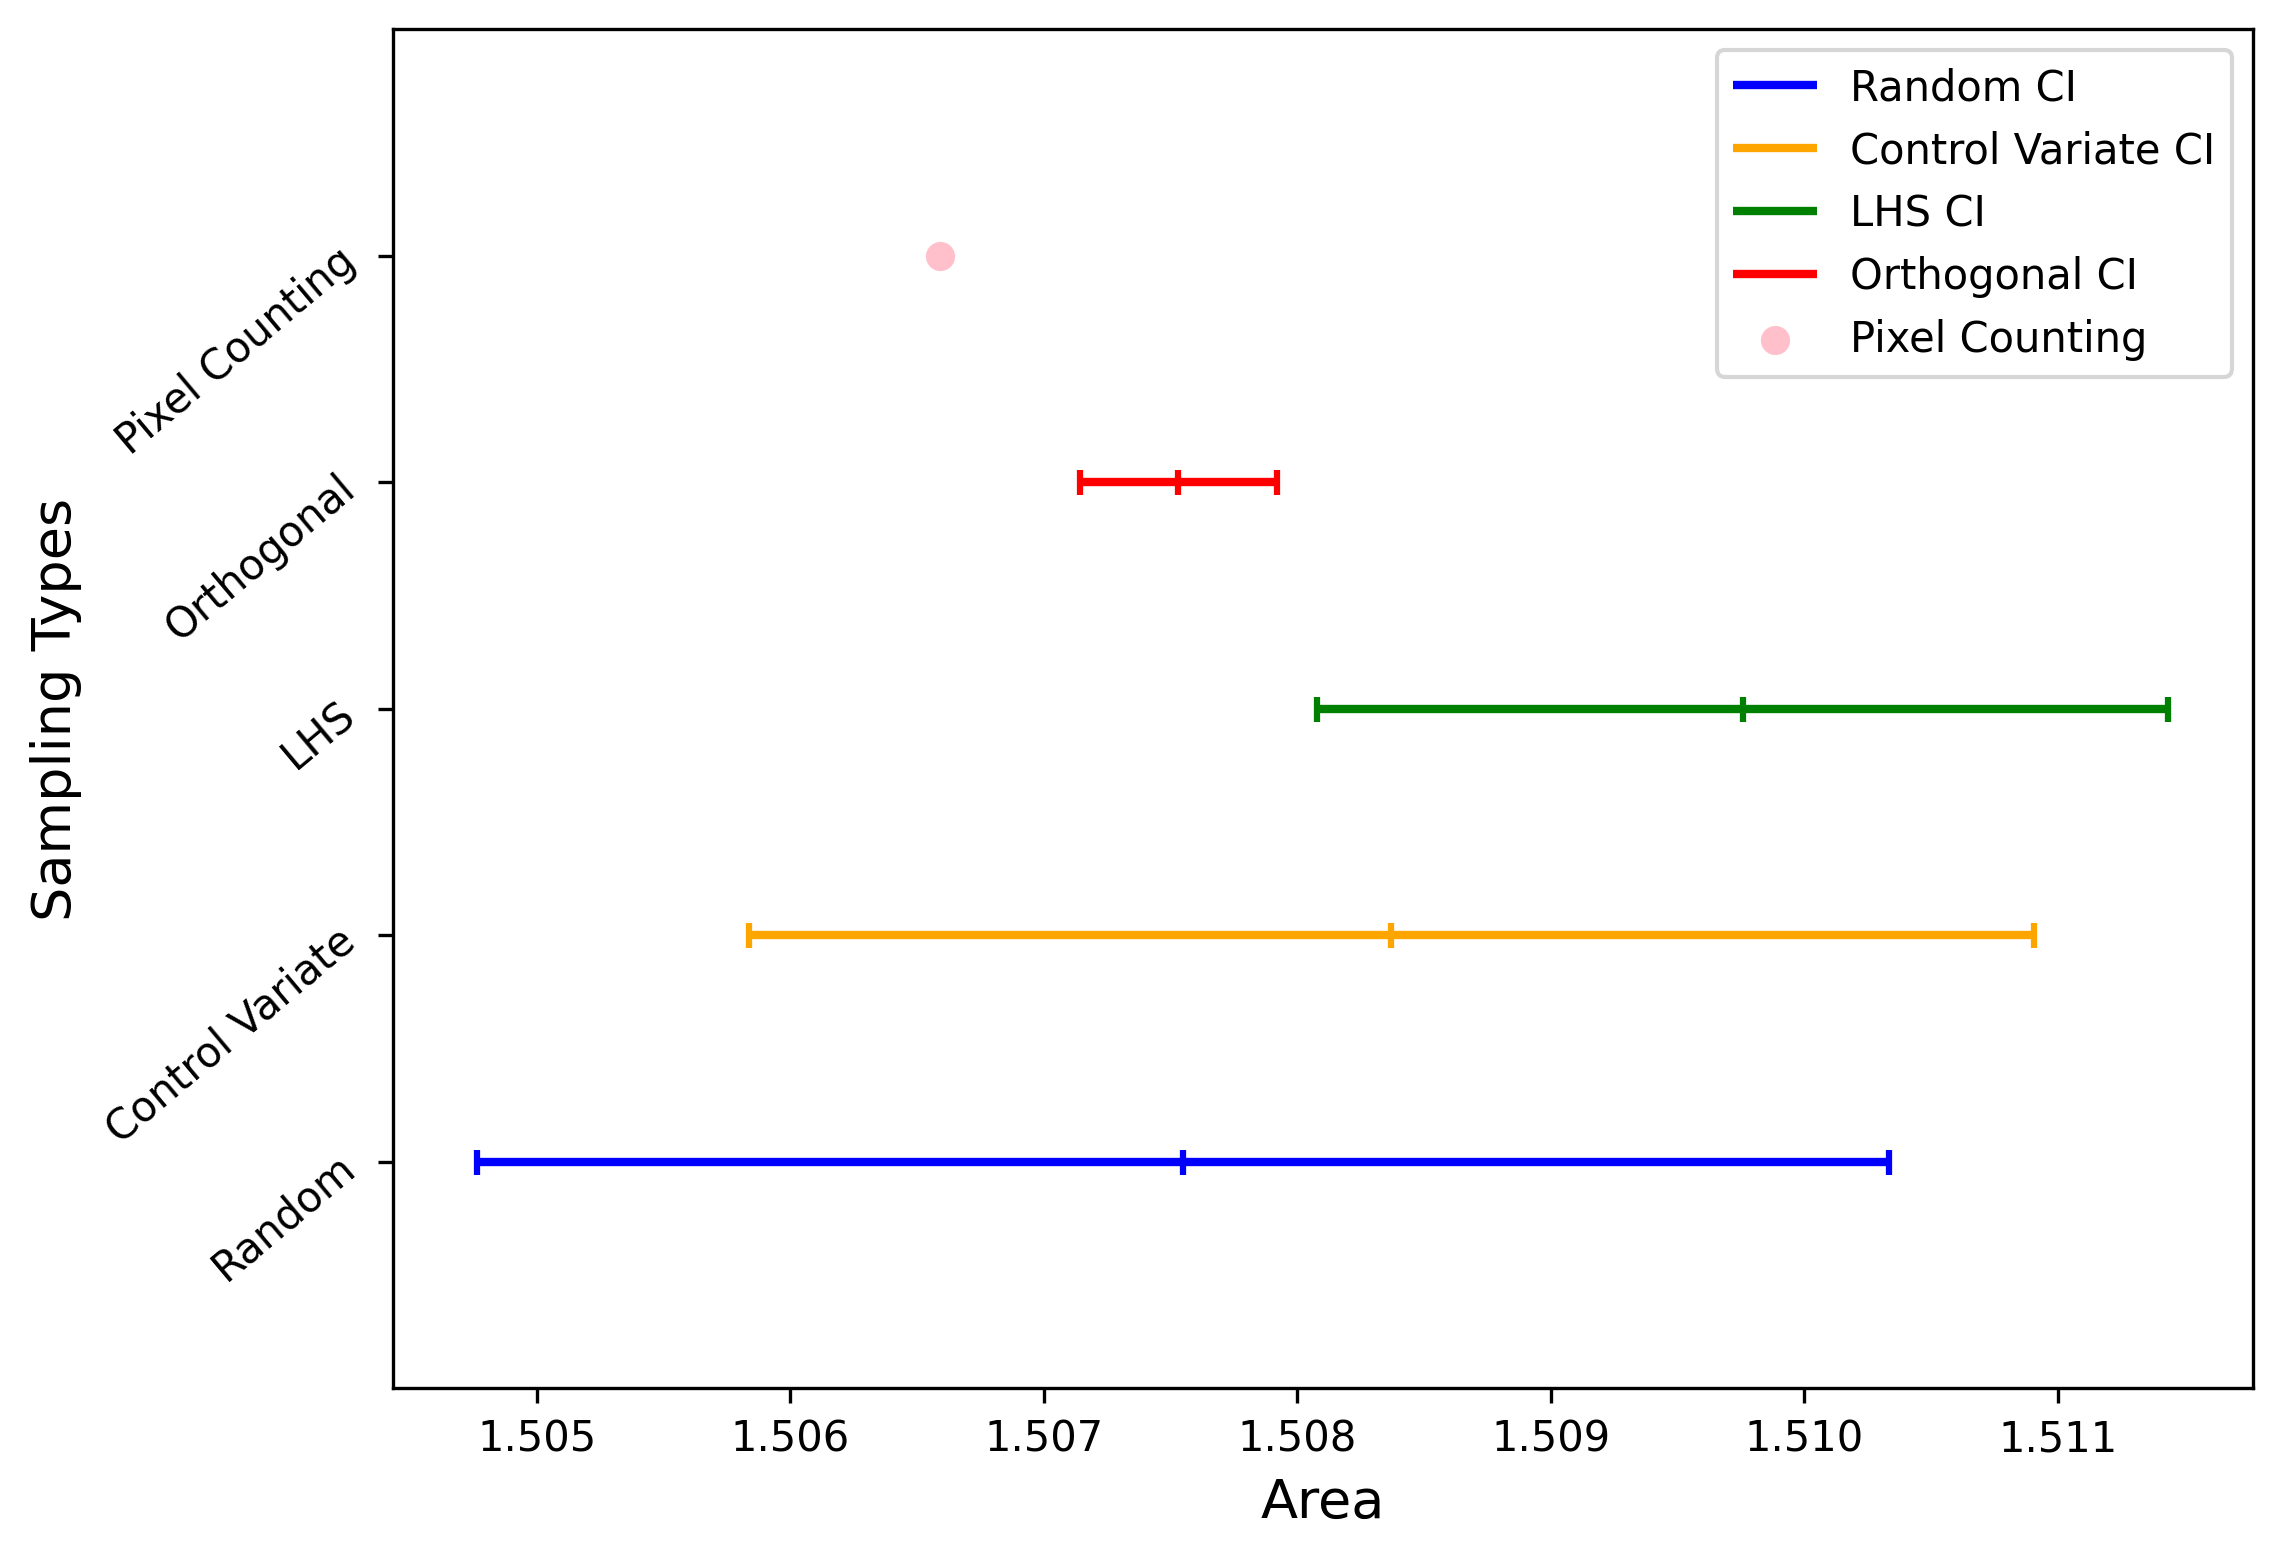

In [13]:
# CI plot

# standard errors
std1 = np.std(df['Random'],ddof=1)
std2 = np.std(df['LHS'],ddof=1)
std3 = np.std(df['Orthogonal'],ddof=1)
std4 = np.std(df['Control Variate'],ddof=1)


# mean values
mean1 = np.mean(df['Random'])
mean2 = np.mean(df['LHS'])
mean3 = np.mean(df['Orthogonal'])
mean4 = np.mean(df['Control Variate'])
mean5 = 1.50659177

# the critical value for 95% confidence intervals
CI = 0.95
CV = norm.ppf(CI+(1-CI)/2) 

# confidence intervals
ci_1 = CV * std1/np.sqrt(len(df['Random']))
ci_2 = CV * std2/np.sqrt(len(df['LHS']))
ci_3 = CV * std3/np.sqrt(len(df['Orthogonal']))
ci_4 = CV * std4/np.sqrt(len(df['Control Variate']))
ci_5 = 0.00000008

# plot the CIs as hline
fig, ax = plt.subplots(figsize=(8,6),dpi=300)

y = [ 1, 2, 3, 4, 5]
labels = ['Random','Control Variate','LHS','Orthogonal','Pixel Counting']

ax.set_yticks(y)
ax.set_yticklabels(labels, rotation=40)

# ax.set_ylim(0,5)
ax.set_ylim(0,6)


ax.hlines(y=1, xmin=mean1-ci_1, xmax=mean1+ci_1,linewidth=2, color='b', label='Random CI')
ax.hlines(y=2, xmin=mean4-ci_4, xmax=mean4+ci_4,linewidth=2, color='orange', label='Control Variate CI')
ax.hlines(y=3, xmin=mean2-ci_2, xmax=mean2+ci_2,linewidth=2, color='g', label='LHS CI')
ax.hlines(y=4, xmin=mean3-ci_3, xmax=mean3+ci_3,linewidth=2, color='r', label='Orthogonal CI')


ax.scatter([mean1-ci_1,mean1,mean1+ci_1],[1,1,1],marker='|', color='b')
ax.scatter([mean4-ci_4,mean4,mean4+ci_4],[2,2,2],marker='|', color='orange')
ax.scatter([mean2-ci_2,mean2,mean2+ci_2],[3,3,3],marker='|', color='g')
ax.scatter([mean3-ci_3,mean3,mean3+ci_3],[4,4,4],marker='|', color='r')


ax.scatter(mean5,5,color='pink',label = 'Pixel Counting')

ax.set_xlabel('Area',fontsize=13)
ax.set_ylabel('Sampling Types',fontsize=13)
ax.legend()
plt.show()

In [14]:
# standard errors
std1 = np.std(df['Random'],ddof=1)
std2 = np.std(df['LHS'],ddof=1)
std3 = np.std(df['Orthogonal'],ddof=1)
std4 = np.std(df['Control Variate'],ddof=1)

# mean values
mean1 = np.mean(df['Random'])
mean2 = np.mean(df['LHS'])
mean3 = np.mean(df['Orthogonal'])
mean4 = np.mean(df['Control Variate'])

# variance values
var1 = np.var(df['Random'])
var2 = np.var(df['LHS'])
var3 = np.var(df['Orthogonal'])
var4 = np.var(df['Control Variate'])

# the sample mean, variance and standard deviations of results from different sampling methods
print('Random Sampling')
print(f'mean: {mean1}; variance: {var1}; standard deviation: {std1}')
print('\n')
print('Control Variate Sampling')
print(f'mean: {mean4}; variance: {var4}; standard deviation: {std4}')
print('\n')
print('Latin hypercube Sampling')
print(f'mean: {mean2}; variance: {var2}; standard deviation: {std2}')
print('\n')
print('Orthogonal Sampling')
print(f'mean: {mean3}; variance: {var3}; standard deviation: {std3}')

# Random Sampling
# mean: 1.50754929; variance: 0.00019982823320589956; standard deviation: 0.014207276312086682


# Control Variate Sampling
# mean: 1.5083697716479327; variance: 0.00016556660246182277; standard deviation: 0.012932091570418127


# Latin hypercube Sampling
# mean: 1.5097564300000004; variance: 7.256690626509981e-05; standard deviation: 0.008561536387721695


# Orthogonal Sampling
# mean: 1.5075306999999996; variance: 3.925138230000018e-06; standard deviation: 0.0019911770616670705

Random Sampling
mean: 1.50754929; variance: 0.0001998282332058999; standard deviation: 0.014207276312086695


Control Variate Sampling
mean: 1.5083697716479327; variance: 0.00016556660246182288; standard deviation: 0.01293209157041813


Latin hypercube Sampling
mean: 1.5097564300000004; variance: 7.256690626509973e-05; standard deviation: 0.00856153638772169


Orthogonal Sampling
mean: 1.5075306999999996; variance: 3.925138230000019e-06; standard deviation: 0.001991177061667071


In [15]:
# Normality Testing
print('Normality Testing')
print('\n')
print('Random Sampling')
stats1, pval1 = test_normality(df['Random'])
print('\n')
print('Control Variate Sampling')
stats4, pval4 = test_normality(df['Control Variate'])
print('\n')
print('Latin hypercube Sampling')
stats2, pval2 = test_normality(df['LHS'])
print('\n')
print('Orthogonal Sampling')
stats3, pval3 = test_normality(df['Orthogonal'])
print('\n')

# Normality Testing


# Random Sampling
# the w test statistic is 0.9880401492118835, the p-value is 0.5111710429191589
# We accept H0, the sample is tested to be normally distributed at 95 confidence interval


# Control Variate Sampling
# the w test statistic is 0.9859434366226196, the p-value is 0.37057510018348694
# We accept H0, the sample is tested to be normally distributed at 95 confidence interval


# Latin hypercube Sampling
# the w test statistic is 0.9907802939414978, the p-value is 0.7274960875511169
# We accept H0, the sample is tested to be normally distributed at 95 confidence interval


# Orthogonal Sampling
# the w test statistic is 0.9961763024330139, the p-value is 0.9947316646575928
# We accept H0, the sample is tested to be normally distributed at 95 confidence interval

Normality Testing


Random Sampling
the w test statistic is 0.9880401492118835, the p-value is 0.5111710429191589
We accept H0, the sample is tested to be normally distributed at 95 confidence interval


Control Variate Sampling
the w test statistic is 0.9859434366226196, the p-value is 0.37057510018348694
We accept H0, the sample is tested to be normally distributed at 95 confidence interval


Latin hypercube Sampling
the w test statistic is 0.9907802939414978, the p-value is 0.7274960875511169
We accept H0, the sample is tested to be normally distributed at 95 confidence interval


Orthogonal Sampling
the w test statistic is 0.9961763024330139, the p-value is 0.9947316646575928
We accept H0, the sample is tested to be normally distributed at 95 confidence interval




In [16]:
print('Two-sample Welch test between the average estimated area from Random-Control Variate, Random-LHS, Random-Orthogonal and LSH-Orthogonal')
print('\n')
print('Random-Control Variate')
actual_value4,acceptance4,dof4 = welch_test(df['Random'],df['Control Variate'],0.95)
print('\n')
print('Random-LHS')
actual_value1,acceptance1,dof1 = welch_test(df['Random'],df['LHS'],0.95)
print('\n')
print('Random-Orthogonal')
actual_value2,acceptance2,dof2 = welch_test(df['Random'],df['Orthogonal'],0.95)
print('\n')
print('LHS-Orthogonal')
actual_value3,acceptance3,dof3 = welch_test(df['LHS'],df['Orthogonal'],0.95)

# Two-sample Welch test between the average estimated area from Random-Control Variate, Random-LHS, Random-Orthogonal and LSH-Orthogonal


# Random-Control Variate
# the Welch-T test statistic is -0.4270760981581987, the degree-of-freedom is 196.27434179759504
# We do not reject H0 with actual t-statistic = -0.4270760981581987 at confidence level p = 0.95 (critical value = 1.9721240974644263)


# Random-LHS
# the Welch-T test statistic is -1.3306008664188482, the degree-of-freedom is 162.52553925189014
# We do not reject H0 with actual t-statistic = -1.3306008664188482 at confidence level p = 0.95 (critical value = 1.974667734261891)


# Random-Orthogonal
# the Welch-T test statistic is 0.01295819721376784, the degree-of-freedom is 102.88772704551721
# We do not reject H0 with actual t-statistic = 0.01295819721376784 at confidence level p = 0.95 (critical value = 1.9832898660592917)


# LHS-Orthogonal
# the Welch-T test statistic is 2.5321063501162815, the degree-of-freedom is 109.67856188856013
# We reject H0 with actual t-statistic = 2.5321063501162815 at confidence level p = 0.95 (critical value = 1.9818298728144577)

Two-sample Welch test between the average estimated area from Random-Control Variate, Random-LHS, Random-Orthogonal and LSH-Orthogonal


Random-Control Variate
the Welch-T test statistic is -0.42707609815819847, the degree-of-freedom is 196.27434179759507
We do not reject H0 with actual t-statistic = -0.42707609815819847 at confidence level p = 0.95 (critical value = 1.9721240974644263)


Random-LHS
the Welch-T test statistic is -1.3306008664188478, the degree-of-freedom is 162.52553925189005
We do not reject H0 with actual t-statistic = -1.3306008664188478 at confidence level p = 0.95 (critical value = 1.974667734261891)


Random-Orthogonal
the Welch-T test statistic is 0.01295819721376783, the degree-of-freedom is 102.88772704551722
We do not reject H0 with actual t-statistic = 0.01295819721376783 at confidence level p = 0.95 (critical value = 1.9832898660592917)


LHS-Orthogonal
the Welch-T test statistic is 2.532106350116283, the degree-of-freedom is 109.67856188856015
We reject H0

In [17]:
print( 'Two-sample F-Test / Fischer test to compare the significance of model robustness of Random-Control Variate, Random-LHS, Random-Orthogonal and LSH-Orthogonal')
print('\n')
print('Random-Control Variate')
actual_value4,acceptance4 = f_test(df['Random'],df['Control Variate'],0.95)
print('\n')
print('Random-LHS')
actual_value1,acceptance1 = f_test(df['Random'],df['LHS'],0.95)
print('\n')
print('Random-Orthogonal')
actual_value2,acceptance2 = f_test(df['Random'],df['Orthogonal'],0.95)
print('\n')
print('LHS-Orthogonal')
actual_value3,acceptance3 = f_test(df['LHS'],df['Orthogonal'],0.95)

# Two-sample F-Test / Fischer test to compare the significance of model robustness of Random-Control Variate, Random-LHS, Random-Orthogonal and LSH-Orthogonal


# Random-Control Variate
# We do not reject H0 with actual t-statistic = 1.2069356394021376 at confidence level p = 0.95 (critical value = 0.6728416631266818-1.4862337676192938)


# Random-LHS
# We reject H0 with actual t-statistic = 2.7537102446656814 at confidence level p = 0.95 (critical value = 0.6728416631266818-1.4862337676192938)


# Random-Orthogonal
# We reject H0 with actual t-statistic = 50.90985883722588 at confidence level p = 0.95 (critical value = 0.6728416631266818-1.4862337676192938)


# LHS-Orthogonal
# We reject H0 with actual t-statistic = 18.48773266390149 at confidence level p = 0.95 (critical value = 0.6728416631266818-1.4862337676192938)

Two-sample F-Test / Fischer test to compare the significance of model robustness of Random-Control Variate, Random-LHS, Random-Orthogonal and LSH-Orthogonal


Random-Control Variate
We do not reject H0 with actual t-statistic = 1.2069356394021387 at confidence level p = 0.95 (critical value = 0.6728416631266823-1.486233767619293)


Random-LHS
We reject H0 with actual t-statistic = 2.753710244665689 at confidence level p = 0.95 (critical value = 0.6728416631266823-1.486233767619293)


Random-Orthogonal
We reject H0 with actual t-statistic = 50.909858837225954 at confidence level p = 0.95 (critical value = 0.6728416631266823-1.486233767619293)


LHS-Orthogonal
We reject H0 with actual t-statistic = 18.487732663901465 at confidence level p = 0.95 (critical value = 0.6728416631266823-1.486233767619293)


In [18]:
print('One-sample T test to compare the expected value of simulations from different samplings to the estimation by pixel counting')
print('\n')
x0 = 1.50659177
# One-sample test: the estiamtions by Random Sampling compared to the literature values 
print('Random Sampling')
actual_value1,acceptance1 =student_t_onesample(df['Random'],x0,0.95)
print('\n')
# One-sample test: the estiamtions by Control Variate Sampling compared to the literature values 
print('Control Variate Sampling')
actual_value4,acceptance4 =student_t_onesample(df['Control Variate'],x0,0.95)
print('\n')
# One-sample test: the estiamtions by Random Sampling compared to the literature values 
print('Latin hypercube Sampling')
actual_value2,acceptance2 =student_t_onesample(df['LHS'],x0,0.95)
print('\n')
# One-sample test: the estiamtions by Random Sampling compared to the literature values 
print('Orthogonal Sampling')
actual_value3,acceptance3 =student_t_onesample(df['Orthogonal'],x0,0.95)

# One-sample T test to compare the expected value of simulations from different samplings to the estimation by pixel counting


# Random Sampling
# We do not reject H0 with actual t-statistic = 0.6739645087253251 at confidence level p = 0.95 (critical value = 1.9842169515086827)


# Control Variate Sampling
# We do not reject H0 with actual t-statistic = 1.3748755475872718 at confidence level p = 0.95 (critical value = 1.9842169515086827)


# Latin hypercube Sampling
# We reject H0 with actual t-statistic = 3.6963692691172687 at confidence level p = 0.95 (critical value = 1.9842169515086827)


# Orthogonal Sampling
# We reject H0 with actual t-statistic = 4.7154520714168 at confidence level p = 0.95 (critical value = 1.9842169515086827


One-sample T test to compare the expected value of simulations from different samplings to the estimation by pixel counting


Random Sampling
We do not reject H0 with actual t-statistic = 0.6739645087253245 at confidence level p = 0.95 (critical value = 1.9842169515086827)


Control Variate Sampling
We do not reject H0 with actual t-statistic = 1.3748755475872714 at confidence level p = 0.95 (critical value = 1.9842169515086827)


Latin hypercube Sampling
We reject H0 with actual t-statistic = 3.6963692691172714 at confidence level p = 0.95 (critical value = 1.9842169515086827)


Orthogonal Sampling
We reject H0 with actual t-statistic = 4.715452071416799 at confidence level p = 0.95 (critical value = 1.9842169515086827)
